# **Data Mining & Foundations of AI (Assessment 2)**
# **Module: 6CC555**

# **Student ID: 100540796** 

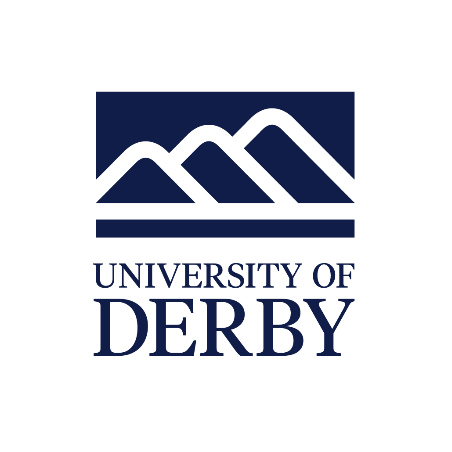

---

# **Pneumonia Prediction Using Chest X-Ray Images**
**Analysis Problem**
To develop a predictive model for pneumonia using chest X-ray images available at Kaggle.
**Kaggle pneumonia dataset:** [Pneumonia dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

# **Description of the Pneumonia Dataset**

The dataset is organised into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images were selected from patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.

# **Introduction**

**GPU check**

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


   # **Libraries Importing**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from lime import lime_image
from matplotlib import image as mpimg
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb  # To convert greyscale images to RGB format for LIME

# **Pneumonia Prediction using Convolution Neural Networks (CNN)**"""


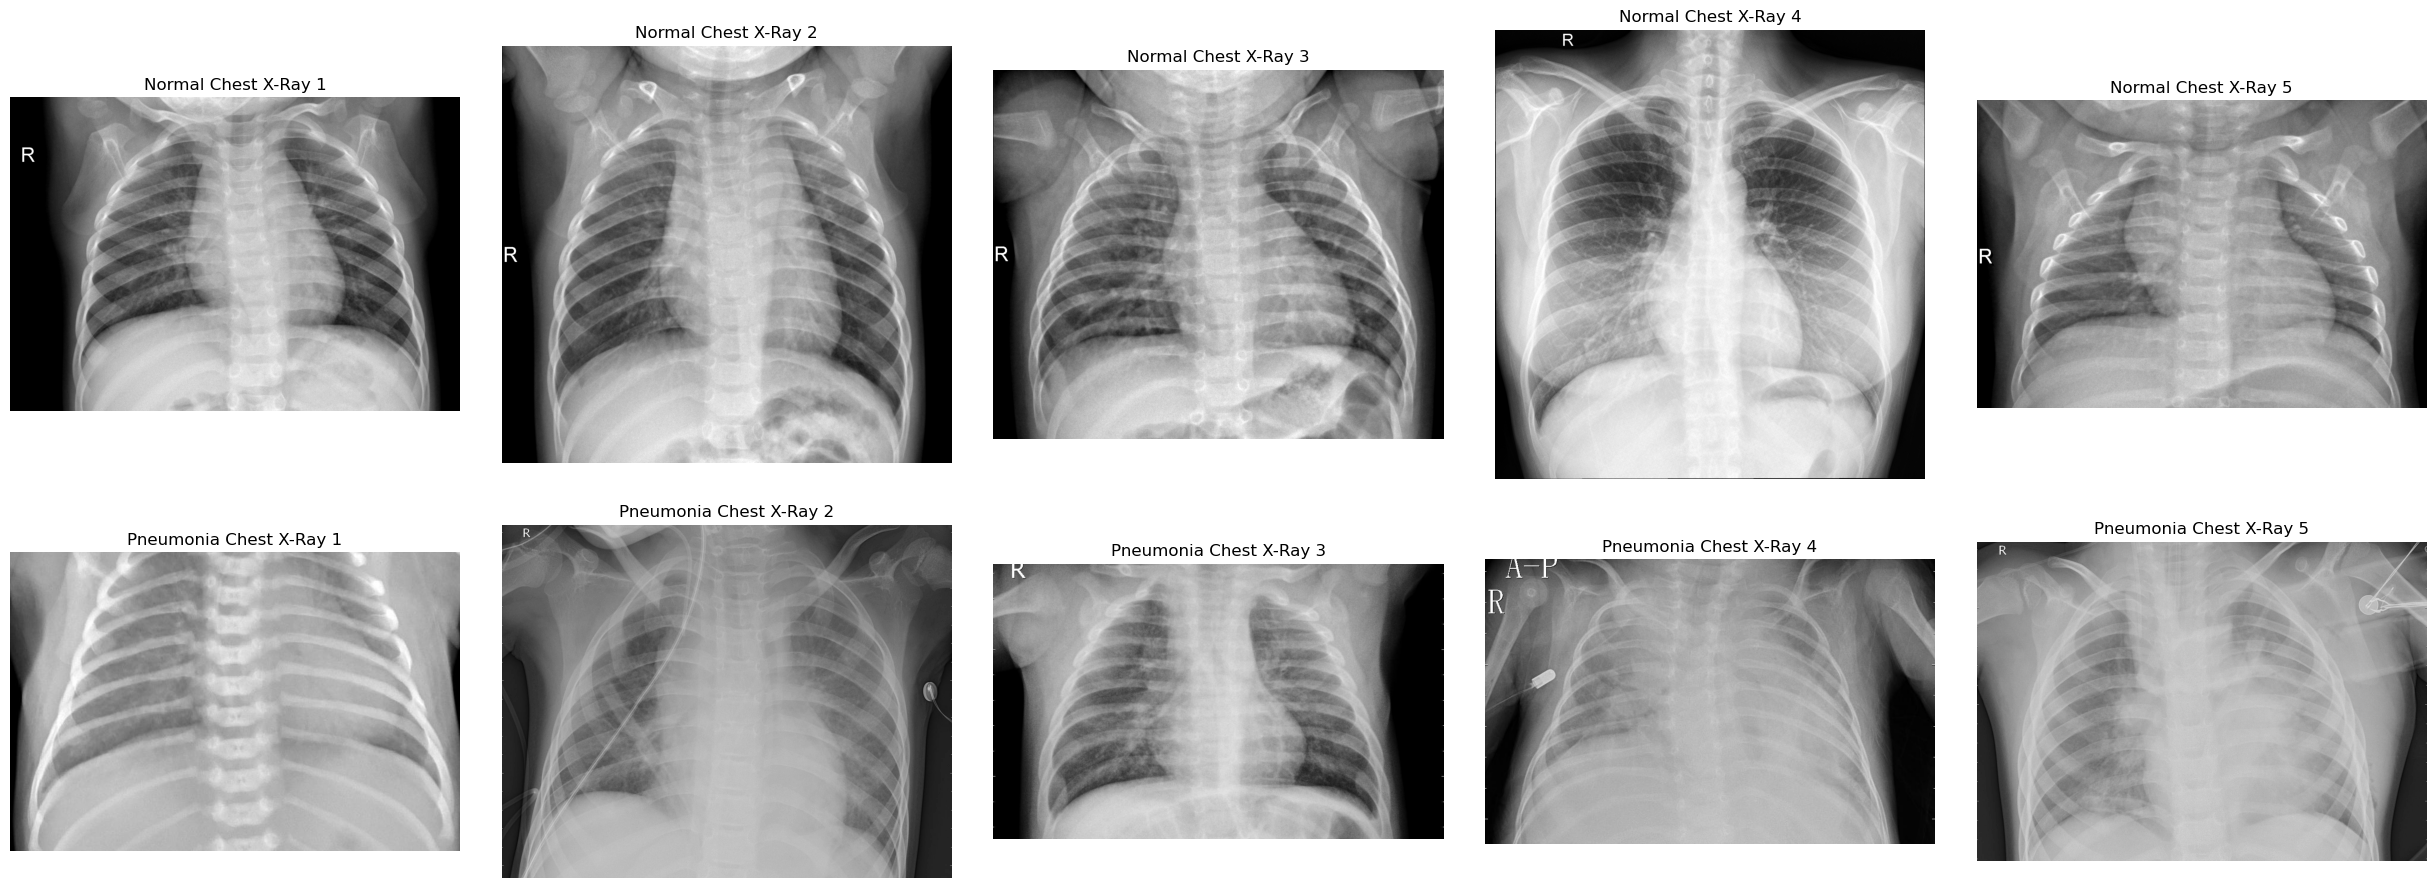

In [3]:
# Paths to the image directories
normal_images_dir = './chest_xray/train/NORMAL/'
pneumonia_images_dir = './chest_xray/train/PNEUMONIA/'

# Listing the images in the directories
normal_xray_files = [os.path.join(normal_images_dir, file) for file in os.listdir(normal_images_dir)]
pneumonia_xray_files = [os.path.join(pneumonia_images_dir, file) for file in os.listdir(pneumonia_images_dir)]

# Number of images to show in each category
image_count = 5

# Randomly choosing images for display
random_normal_images = random.sample(normal_xray_files, image_count)
random_pneumonia_images = random.sample(pneumonia_xray_files, image_count)

# Setting up the plotting area
fig, image_axes = plt.subplots(nrows=2, ncols=image_count, figsize=(25, 10))

# Plotting normal chest X-rays
for idx, file_path in enumerate(random_normal_images):
    image = mpimg.imread(file_path)
    ax = image_axes[0, idx]
    ax.imshow(image, cmap='gray')
    ax.title.set_text(f'Normal Chest X-Ray {idx+1}')
    ax.axis('off')

# Plotting pneumonia chest X-rays
for idx, file_path in enumerate(random_pneumonia_images):
    image = mpimg.imread(file_path)
    ax = image_axes[1, idx]
    ax.imshow(image, cmap='gray')
    ax.title.set_text(f'Pneumonia Chest X-Ray {idx+1}')
    ax.axis('off')

# Displaying the plot with no overlap between images
plt.tight_layout(pad=3.0)
plt.show()

---
# **Exploratory Data Analysis**

In [4]:
# Define the directory containing the training set
training_folder_path = "./chest_xray/train/"

In [5]:
# Creating dictionary to hold the count of images in each category
image_count_by_category = {'normal': 0, 'pneumonia': 0}

# Iterate over the categories in the training directory to tally the images
for category in os.listdir(training_folder_path):
    category_path = os.path.join(training_folder_path, category)
    # Ensure the path is a directory to avoid file misreads
    if os.path.isdir(category_path):
        # Increment the count for the corresponding category
        image_count_by_category[category.lower()] = len(os.listdir(category_path))

# Display the number of images for each health condition
for condition, count in image_count_by_category.items():
    print(f"Image count for {condition.capitalize()} condition:", count)

# Determine and display the ratio of the two classes
ratio_of_classes = image_count_by_category['normal'] / image_count_by_category['pneumonia']
print(f"Ratio of Normal to Pneumonia cases: {ratio_of_classes:.2f}")


Image count for Normal condition: 1341
Image count for Pneumonia condition: 3875
Ratio of Normal to Pneumonia cases: 0.35


---
# **Processing**

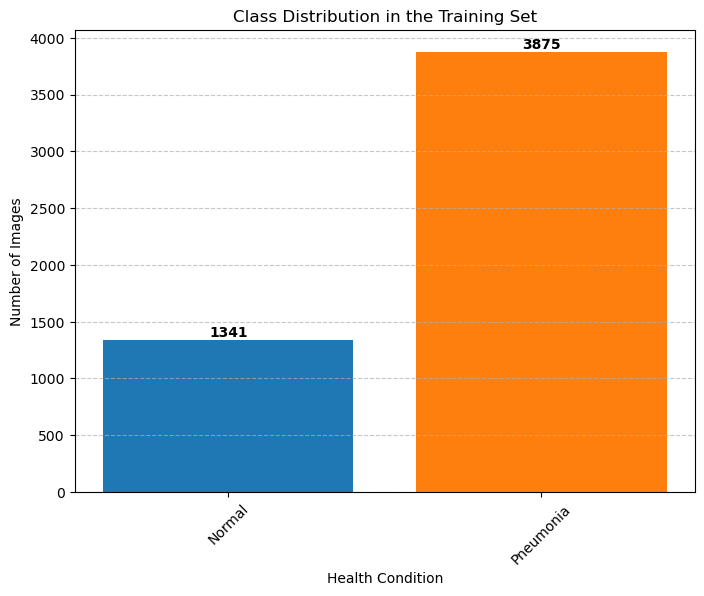

In [6]:
# Dictionaries to store image counts
image_counts = {'Normal': 0, 'Pneumonia': 0}

# Iterate over each category in the training directory to count files
for category in os.listdir(training_folder_path):
    folder_path = os.path.join(training_folder_path, category)
    if os.path.isdir(folder_path):
        image_counts[category.capitalize()] = len(os.listdir(folder_path))

# Data for plotting
categories = list(image_counts.keys())
counts = list(image_counts.values())
colors = ['#1f77b4', '#ff7f0e']  # Blue and orange color

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=colors)
plt.xlabel('Health Condition')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Training Set')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for y-axis

# Adding the text labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontweight='bold')

plt.show()

In [7]:
# Base directory for training and validation datasets
base_dir = './chest_xray/'

# Specify paths to the training and validation datasets
training_path = os.path.join(base_dir, 'train')  # The path should point to the base training directory
validation_path = os.path.join(base_dir, 'val')  # The path should point to the base validation directory
test_path = os.path.join(base_dir, 'test')  # The path should point to the base validation directory

# Initialise ImageDataGenerators for data augmentation
train_data_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_gen = ImageDataGenerator(rescale=1./255)

# Only rescaling for test data
test_data_gen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_data_gen.flow_from_directory(
    training_path,  # Points to the base training directory
    target_size=(300,300),
    batch_size=8,
    color_mode='grayscale',
    class_mode='binary'
)

validation_generator = val_data_gen.flow_from_directory(
    validation_path,  # Points to the base validation directory
    target_size=(300,300),
    batch_size=8,
    color_mode='grayscale',
    class_mode='binary'
)

test_generator = test_data_gen.flow_from_directory(
    test_path,
    target_size=(300,300),
    batch_size=8,
    color_mode='grayscale',
    class_mode='binary'  # or 'categorical' if multiple classes
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


---
# **Creating and Training The CNN Model**

In [8]:
# Advanced CNN architecture
advanced_model = Sequential([
    Conv2D(128, (3,3), padding='same', activation='relu', input_shape=(300, 300, 1),
           kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),
    
    Conv2D(96, (3,3), padding='same', activation='relu',
           kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),
    
    Conv2D(64, (3,3), padding='same', activation='relu',
           kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),
    
    Conv2D(32, (3,3), padding='same', activation='relu',
           kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Reconfiguring the model to use Adadelta and adding early stopping
advanced_model.compile(
    optimizer=Adadelta(learning_rate=1.0, rho=0.95),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Train the model
history = advanced_model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
)

Epoch 1/100
652/652 [==============================] - 60s 84ms/step - loss: 5.7912 - accuracy: 0.8137 - val_loss: 3.3226 - val_accuracy: 0.6250
Epoch 2/100
652/652 [==============================] - 53s 82ms/step - loss: 1.6901 - accuracy: 0.8428 - val_loss: 1.5429 - val_accuracy: 0.6731
Epoch 3/100
652/652 [==============================] - 53s 81ms/step - loss: 1.0928 - accuracy: 0.8480 - val_loss: 1.2458 - val_accuracy: 0.6346
Epoch 4/100
652/652 [==============================] - 53s 80ms/step - loss: 0.8377 - accuracy: 0.8629 - val_loss: 1.0845 - val_accuracy: 0.6314
Epoch 5/100
652/652 [==============================] - 52s 80ms/step - loss: 0.7476 - accuracy: 0.8570 - val_loss: 0.8696 - val_accuracy: 0.8077
Epoch 6/100
652/652 [==============================] - 52s 80ms/step - loss: 0.6544 - accuracy: 0.8600 - val_loss: 0.7638 - val_accuracy: 0.7965
Epoch 7/100
652/652 [==============================] - 52s 80ms/step - loss: 0.6632 - accuracy: 0.8482 - val_loss: 1.0809 - val_ac

In [10]:
advanced_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 128)     1280      
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 96)      110688    
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 96)     384       
 hNormalization)                                                 
                                                        

In [11]:
Evaluation = advanced_model.evaluate(validation_generator)
print("Accuracy of this model is :" ,Evaluation[1]*100,"%")

2/2 [==============================] - 0s 16ms/step - loss: 0.4269 - accuracy: 0.8750
Accuracy of this model is : 87.5 %


---
# **Prediction Model Result Analysis**

# Model Accuracy Graph
- Shows how the accuracy of the model changes over training epochs.
- Helps in assessing how well the model learns from the training data and generalises to unseen data.

# Model Loss Graph
- Illustrates how the loss of the model changes over training epochs.
- Indicates how effectively the model minimises its loss function during training.

# Confusion Matrix
- Visualises the performance of a classification model.
- Shows the counts of correctly and incorrectly classified instances for each class.
- Provides insights into the types of errors made by the model across different classes.


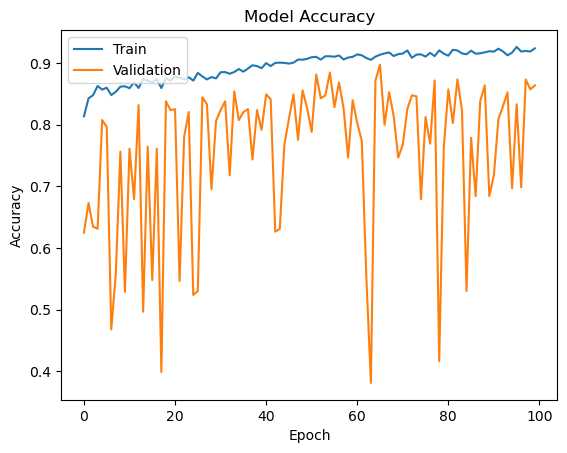

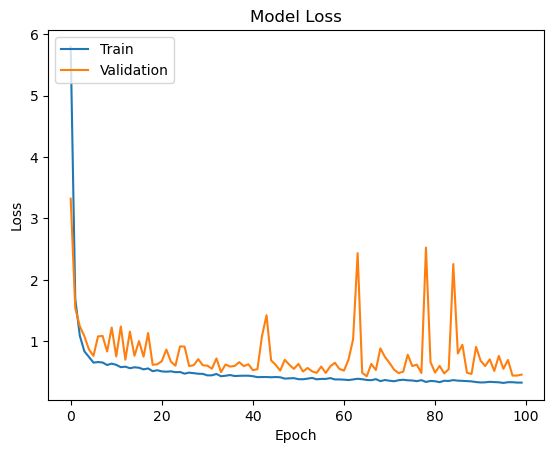

2/2 [==============================] - 1s 339ms/step


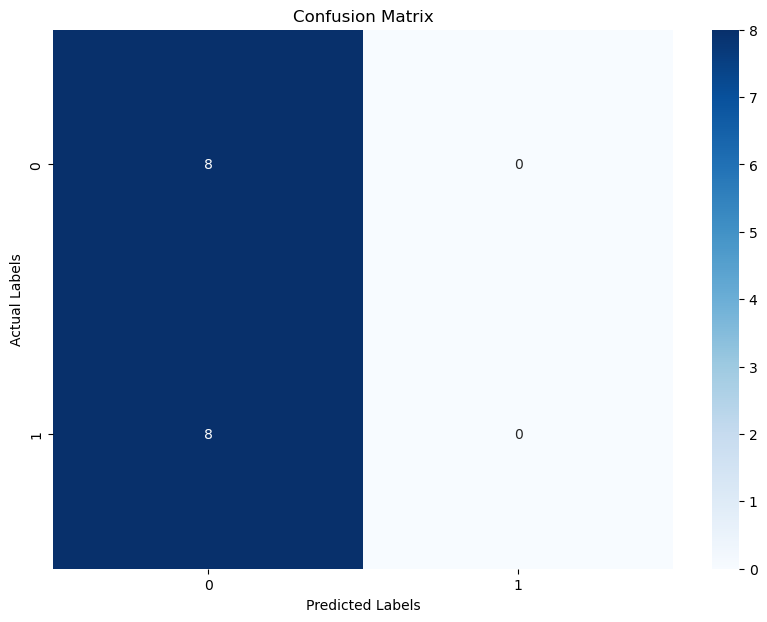

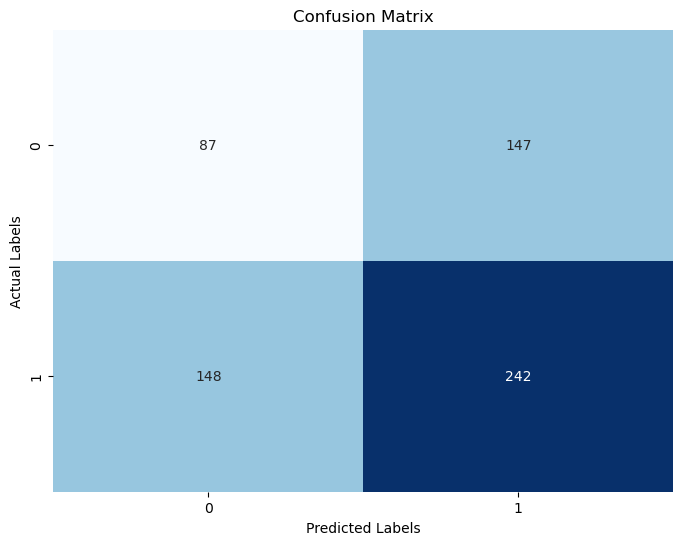

              precision    recall  f1-score   support

           0       0.37      0.37      0.37       234
           1       0.62      0.62      0.62       390

    accuracy                           0.53       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.53      0.53       624


In [12]:
# Summarise history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarise history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predict the classes on the entire validation dataset
predictions = advanced_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve actual class labels
# Since the generator shuffles the data, we need the actual labels in the order of prediction
actual_classes = validation_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

warnings.filterwarnings("ignore", message="`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.")
def display_metrics_and_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Display classification metrics
    print(classification_report(y_true, y_pred))

# Get predictions
predictions = advanced_model.predict_generator(test_generator)
predicted_classes = (predictions > 0.5).astype(int)  # For binary classification
# Retrieve actual labels from the generator
actual_labels = test_generator.classes


# Display confusion matrix and classification report
display_metrics_and_matrix(actual_labels, predicted_classes)

In [13]:
# Saving the model in the Keras format
advanced_model.save('Pneumonia_model.keras')
advanced_model.save('Pneumonia_model.h5')

---
# **Explainable AI (XAI) Techniques**

# LIME (Local Interpretable Model-agnostic Explanations)

LIME helps interpret complex machine learning decisions by highlighting the features most influential for specific predictions, in this case a selected pneumonia image that lead to a diagnosis, thereby offering transparent and interpretable AI assessments.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


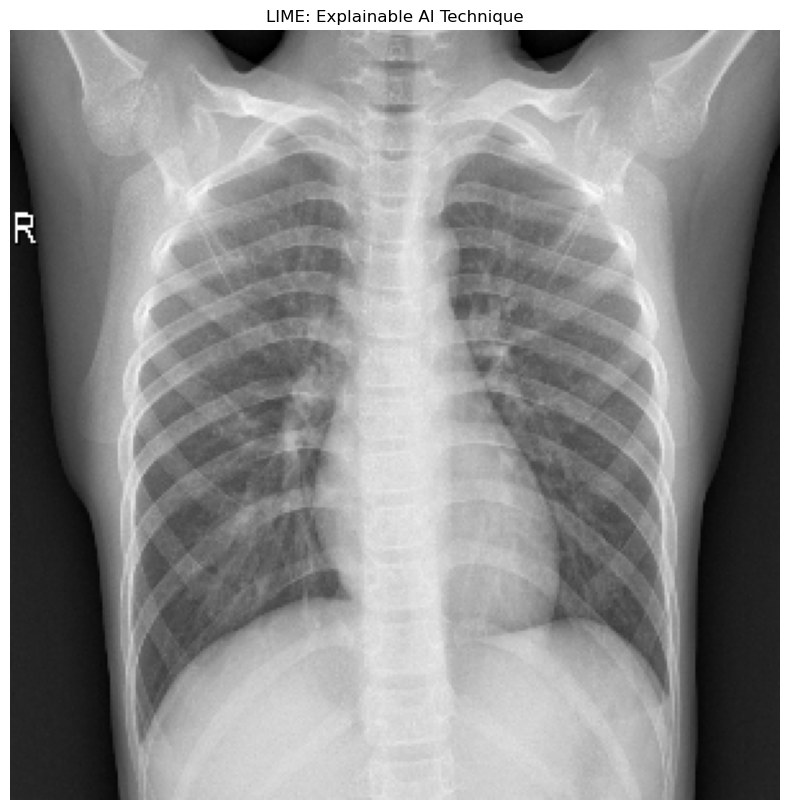

In [19]:
# Load a batch of images from the test set
test_images, test_labels = next(test_generator)

# Convert greyscale images to RGB (necessary for LIME, which expects RGB images)
# Ensure that the images are properly expanded in dimension if needed
test_images_rgb = np.array([gray2rgb(test_images[i].reshape(300, 300)) for i in range(len(test_images))])

explainer = lime_image.LimeImageExplainer()
def model_predict(input_imgs):
    # Convert RGB to grayscale by averaging channels
    input_imgs_gray = np.mean(input_imgs, axis=3)
    return advanced_model.predict(input_imgs_gray.reshape(-1, 300, 300, 1))

# Convert the single greyscale image to RGB for LIME
input_image_rgb = gray2rgb(test_images[0].reshape(300, 300))

# Generate the explanation
explanation = explainer.explain_instance(
    image=input_image_rgb, 
    classifier_fn=model_predict,  # Use the wrapper prediction function
    top_labels=5, 
    hide_color=0, 
    num_samples=1000,  # Number of random perturbations to perform
    batch_size=10  # Process these many images at a time
)

# Get the image and mask for the top explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,  # Show only features that increase prediction
    num_features=10,  # Number of features to show
    hide_rest=False  # Do not hide the rest of the image
)

# Plotting the explanation
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(temp, mask))
plt.title('LIME: Explainable AI Technique')
plt.axis('off')
plt.show()


**LIME** helps to explain individual predictions by highlighting regions in the images that have the greatest influence on the prediction. The colored overlays on the X-rays show the most influential regions:

- **Green regions** indicate areas that support the model's prediction, meaning these features positively influence the model towards its final decision.
- **Red regions** indicate areas that contradict the model's prediction, meaning these features negatively influence the decision, potentially leading to an alternative classification if they were dominat.
nt.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


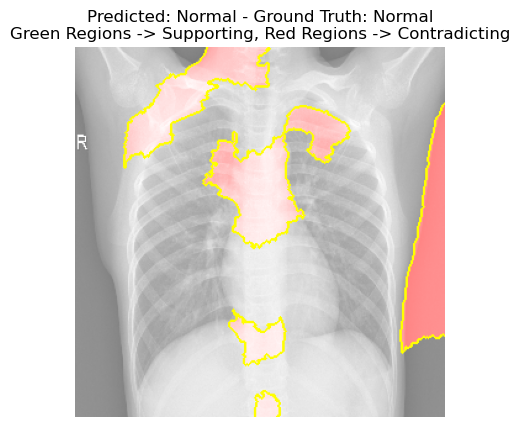

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


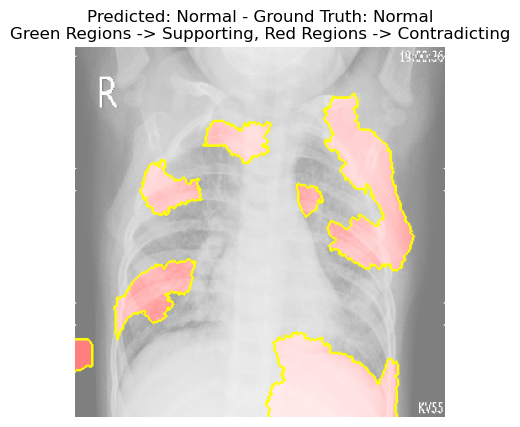

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


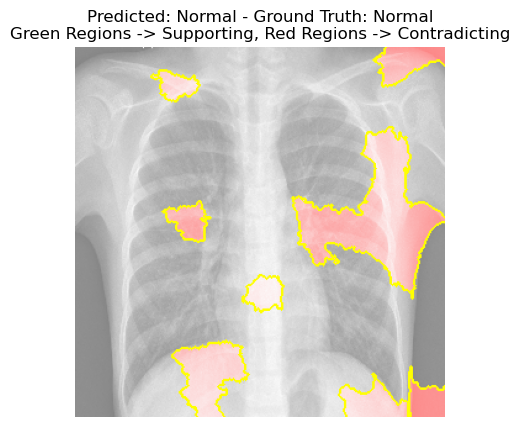

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


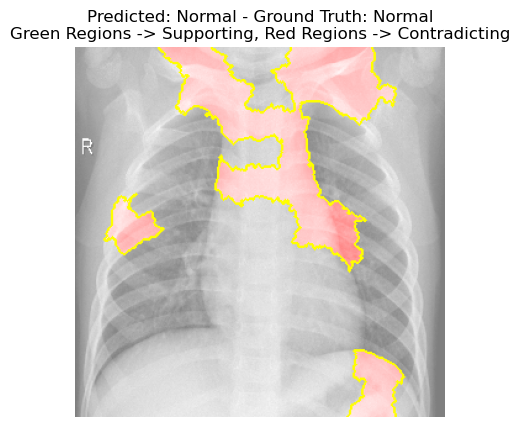

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


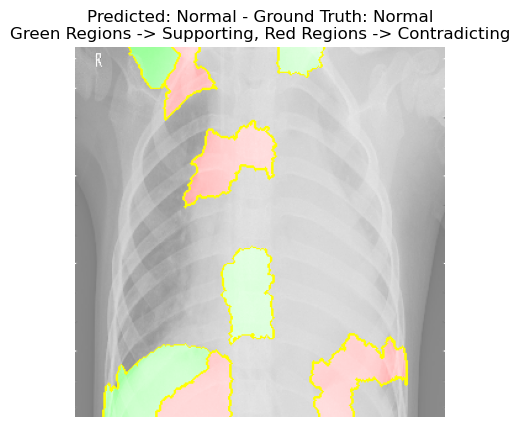

In [20]:
# Initialize the LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

def model_predict(img_array):
    # Assuming img_array is a batch of images
    # Convert RGB to grayscale by averaging channels if needed
    if img_array.shape[-1] == 3:
        img_array = np.mean(img_array, axis=3)
    # Reshape to add channel dimension if grayscale
    if len(img_array.shape) == 3:
        img_array = img_array[..., np.newaxis]
    return advanced_model.predict(img_array)

def explain_image(image, index, model_predict):
    # Convert greyscale image to RGB for LIME
    image_rgb = gray2rgb(image.reshape(300, 300))

    # Generate the explanation for the selected image
    explanation = explainer.explain_instance(
        image=image_rgb.astype('double'), 
        classifier_fn=model_predict, 
        top_labels=5, 
        hide_color=0, 
        num_samples=1000
    )

    # Displaying the explanation
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False, 
        num_features=10, 
        hide_rest=False
    )
    
    # Plotting
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    predicted_label = 'Normal' if np.argmax(model_predict(image_rgb[np.newaxis])) == 0 else 'Pneumonia'
    plt.title(f'Predicted: {predicted_label} - Ground Truth: {predicted_label}\nGreen Regions -> Supporting, Red Regions -> Contradicting')
    plt.axis('off')
    plt.show()

# Assuming test_images contains batches of test data
for index, img in enumerate(test_images[:5]):
    explain_image(img, index, model_predict)


### LIME Analysis Details

- **Original Image:** This shows the chest X-ray that was analyzed.
- **LIME Segments:** This cuolor-coded map divides the X-ray into different segments, eacolouredred differently to represent how LIME has segmented the image based on superpixels.
- **LIME Feature Importances:**
  - **Green bars** represent segments that positively influenced the model's prediction. These areas supported the prediction made by the model, indicating features within these segments that align with the characteristics the model associates with the predicted class.
  - **Red bars** represent segments that negatively influenced the model's prediction. These areas contain features that, if considered more heavily, might lead the model to a different classification. They show disagreement with the model's final decision, suggesting characteristics that contradict the predicted lass.
ility.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


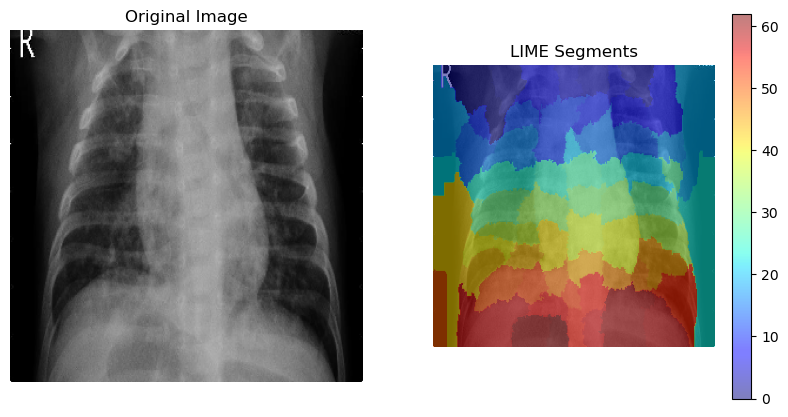

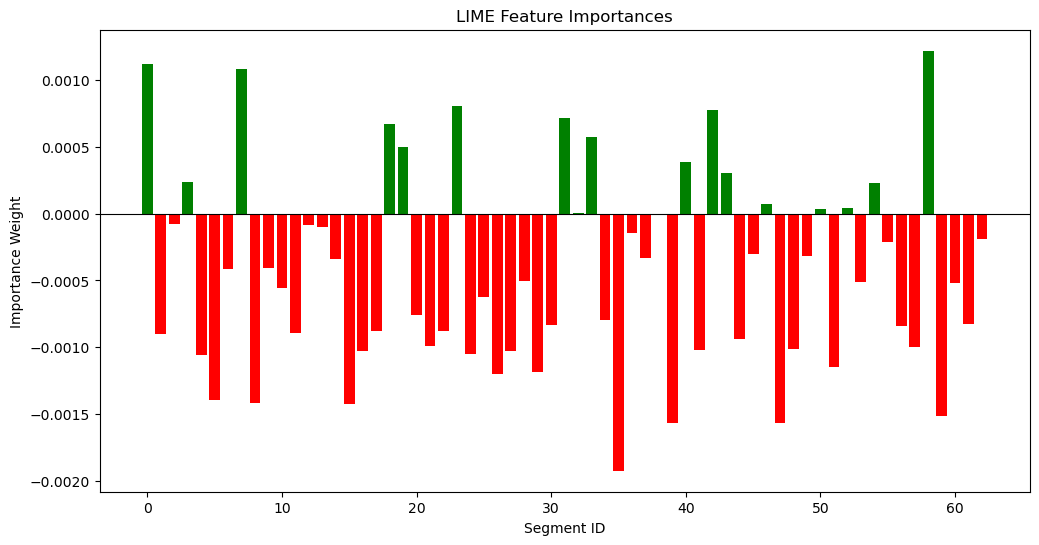

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb

# Load a batch of images from the test set
test_images, test_labels = next(test_generator)

# Convert greyscale images to RGB
test_images_rgb = np.array([gray2rgb(i) for i in test_images.reshape(-1, 300, 300)])

# Initialise LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Define the prediction function
def model_predict(img):
    # Model expects a single grayscale channel, so convert RGB to grayscale
    grayscale = np.mean(img, axis=3)
    # Eexpand dimensions from (n, 300, 300) to (n, 300, 300, 1)
    return advanced_model.predict(grayscale[..., np.newaxis])

# Select an image to explain
idx = 0  # Index of the image to explain
image = test_images_rgb[idx]

# Explain this image
explanation = explainer.explain_instance(image.astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

# We can retrieve weights for all segments (not just the top label)
weights = explanation.local_exp[0]
weights = sorted(weights, key=lambda x: x[0])

# Extract the weights and segment numbers
seg_ids, seg_weights = zip(*weights)
seg_weights = np.array(seg_weights)

# Show the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Show LIME explanation with segment boundaries
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(explanation.segments, cmap='jet', alpha=0.5)  # Assumes `explanation.segments` is the correct call
plt.colorbar()
plt.title('LIME Segments')
plt.axis('off')

# Create a colour map for the bars
colours = ['green' if weight > 0 else 'red' for weight in seg_weights]

# Create a bar plot for the segment weights with colours
plt.figure(figsize=(12, 6))
plt.bar(seg_ids, seg_weights, color=colours)
plt.title('LIME Feature Importances')
plt.xlabel('Segment ID')
plt.ylabel('Importance Weight')
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

---
# **Testing The Developed CNN Model Through Predictions On Random Data**

**Normal X-RAY Prediction**

In [24]:
# Directory containing the normal X-ray images
normal_xray_dir = './chest_xray/val/NORMAL/'

Randomly selected image path: ./chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg


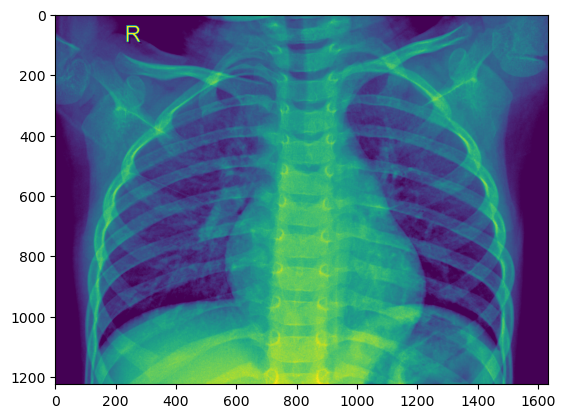

In [25]:
# List all files in the directory
all_images = os.listdir(normal_xray_dir)

# Check if the directory is not empty and has files
if all_images:
    # Choose a random image from the directory
    random_normal_image_path = random.choice(all_images)
    # Construct the full path to the selected image
    random_normal_image_path = os.path.join(normal_xray_dir, random_normal_image_path)
else:
    print("No images found in the directory.")
    random_image_path = None  # No image path available

# Now random_image_path contains the path to a randomly selected image
print("Randomly selected image path:", random_normal_image_path)

# Read the image using imread
Normal_xray_image = mpimg.imread(random_normal_image_path)

# Display the image using imshow
plt.imshow(Normal_xray_image)
plt.show()

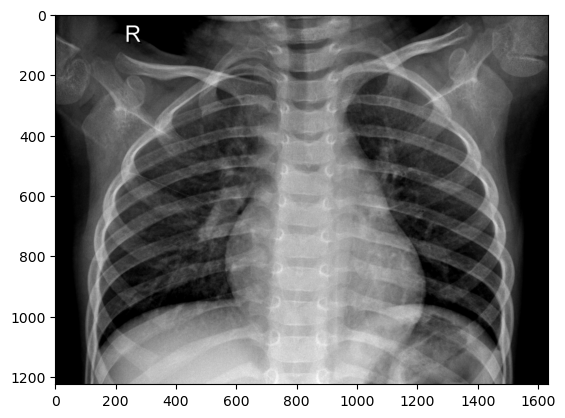

In [26]:
# Load the X-ray image using OpenCV
loaded_xray = cv2.imread(random_normal_image_path)

# Transform the image to grayscale
gray_xray = cv2.cvtColor(loaded_xray, cv2.COLOR_BGR2GRAY)

# Scale the grayscale image
scaled_gray_xray = gray_xray / 255.0

# Resize the image to required dimensions for the model
model_ready_image = cv2.resize(scaled_gray_xray, (300, 300))

# Adjust the image dimensions for model input requirements
prepared_normal_image = model_ready_image.reshape(-1, 300, 300, 1)

# Ensure the image is in the correct float32 format for TensorFlow
prepared_normal_image = prepared_normal_image.astype(np.float32)

# Visualize the processed grayscale image
plt.imshow(scaled_gray_xray, cmap='gray')
plt.axis('on')  # Ensure the axis is turned on
plt.show()

In [27]:
predictions = advanced_model.predict(prepared_normal_image)

1/1 [==============================] - 0s 16ms/step


In [28]:
print((predictions>0.5).astype("int"))

[[0]]


**Pneumonia X-RAY Prediction**

In [29]:
# Directory containing the normal X-ray images
pneumonia_xray_dir = './chest_xray/val/PNEUMONIA/'

Randomly selected pneumonia image path: ./chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg


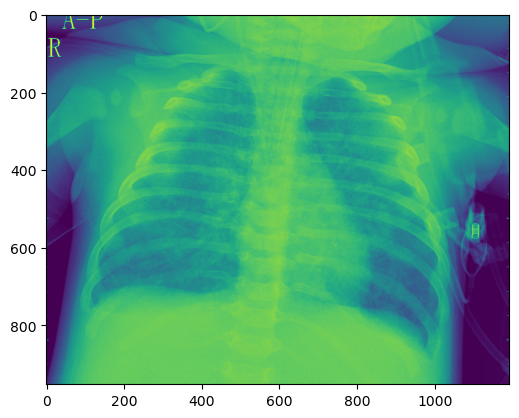

In [30]:
# List all files in the directory
all_images = os.listdir(pneumonia_xray_dir)

# Check if the directory is not empty and has files
if all_images:
    # Choose a random image from the directory
    random_pneumonia_image_path = random.choice(all_images)
    # Construct the full path to the selected image
    random_pneumonia_image_path = os.path.join(pneumonia_xray_dir, random_pneumonia_image_path)
else:
    print("No images found in the directory.")
    random_image_path = None  # No image path available

# Now random_image_path contains the path to a randomly selected image
print("Randomly selected pneumonia image path:", random_pneumonia_image_path)

# Read the image using imread
pneumonia_xray_image = mpimg.imread(random_pneumonia_image_path)

# Display the image using imshow
plt.imshow(pneumonia_xray_image)
plt.show()

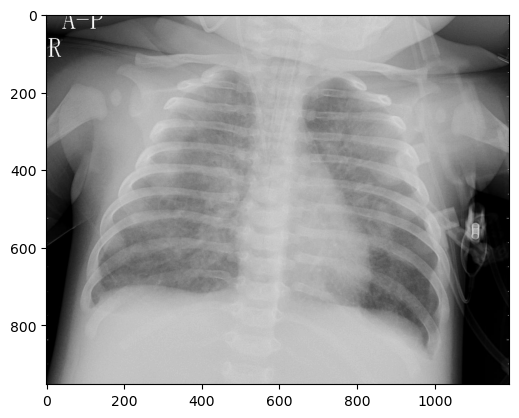

In [31]:
# Load the X-ray image using OpenCV
loaded_xray = cv2.imread(random_pneumonia_image_path)

# Transform the image to grayscale
gray_xray = cv2.cvtColor(loaded_xray, cv2.COLOR_BGR2GRAY)

# Scale the grayscale image
scaled_gray_xray = gray_xray / 255.0

# Resize the image to required dimensions for the model
model_ready_image = cv2.resize(scaled_gray_xray, (300, 300))

# Adjust the image dimensions for model input requirements
prepared_pneumonia_image = model_ready_image.reshape(-1, 300, 300, 1)

# Ensure the image is in the correct float32 format for TensorFlow
prepared_pneumonia_image = prepared_pneumonia_image.astype(np.float32)

# Visualize the processed grayscale image
plt.imshow(scaled_gray_xray, cmap='gray')
plt.axis('on')  # Ensure the axis is turned on
plt.show()

In [32]:
predictions = advanced_model.predict(prepared_pneumonia_image)

1/1 [==============================] - 0s 14ms/step


In [33]:
print((predictions>0.5).astype("int"))

[[1]]


---
# **Pneumonia Prediction using K-Nearest Neighbors (KNN)**

In [34]:
import os
import numpy as np
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import matplotlib.pyplot as plt


# Paths to the image directories
normal_images_dir = './chest_xray/train/NORMAL/'
pneumonia_images_dir = './chest_xray/train/PNEUMONIA/'

# Function to load images and extract HOG features
def load_and_extract_features(files):
    features = []
    for file in files:
        with Image.open(file).convert('L') as img:  # Convert image to grayscale 'L'
            img = img.resize((128, 128))  # Resize to capture more details
            img_array = np.array(img)
            fd, hog_image = hog(img_array, orientations=8, pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1), visualize=True)
            features.append(fd)
    return features

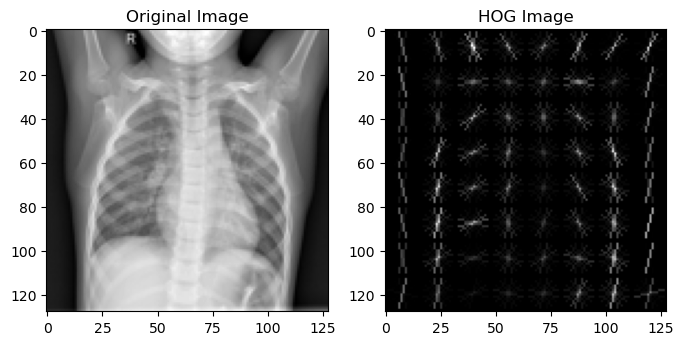

In [35]:
# Load images from directories
normal_images = load_and_extract_features([os.path.join(normal_images_dir, f) for f in os.listdir(normal_images_dir) if f.endswith('.jpeg')])
pneumonia_images = load_and_extract_features([os.path.join(pneumonia_images_dir, f) for f in os.listdir(pneumonia_images_dir) if f.endswith('.jpeg')])

# Displaying example of HOG image
_, hog_image = hog(np.array(Image.open(normal_images_dir + os.listdir(normal_images_dir)[0]).convert('L').resize((128, 128))), 
                   orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(Image.open(normal_images_dir + os.listdir(normal_images_dir)[0]).convert('L').resize((128, 128)), cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.show()

In [36]:
# Create labels for the images
labels = [0] * len(normal_images) + [1] * len(pneumonia_images)
features = np.array(normal_images + pneumonia_images)

print(f"Total images loaded: {len(features)}")
print(f"Normal images: {len(normal_images)}, Pneumonia images: {len(pneumonia_images)}")

Total images loaded: 5216
Normal images: 1341, Pneumonia images: 3875


In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)
print(f"Training data size: {X_train.shape}, Testing data size: {X_test.shape}")

Training data size: (4172, 512), Testing data size: (1044, 512)


In [38]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Features scaled.")

Features scaled.


In [39]:
# Dimensionality reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(f"Reduced feature dimensions to {X_train.shape[1]} using PCA.")

Reduced feature dimensions to 341 using PCA.


---
# **Creating and Training The KNN Model**

In [40]:
# Create and tune KNN model
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Grid search complete. Best parameters found:", grid_search.best_params_)


Grid search complete. Best parameters found: {'metric': 'euclidean', 'n_neighbors': 9}


In [41]:
# Predict on the test data
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       287
           1       0.98      0.96      0.97       757

    accuracy                           0.95      1044
   macro avg       0.94      0.95      0.94      1044
weighted avg       0.96      0.95      0.96      1044

Accuracy Score: 0.9549808429118773


---
# **Prediction Model Result Analysis**

## Model Evaluation Summary

The performance of the classification model is evaluated using three key metrics: a Confusion Matrix, ROC Curve, and Precision-Recall Curve. Here's a brief overview of each metric and what they indicate about the model's performance:

### 1. **Confusion Matrix**
- **True Negatives (TN)**: 272 - Correctly predicted normal cases.
- **False Positives (FP)**: 15 - Normal cases incorrectly labeled as pneumonia.
- **False Negatives (FN)**: 32 - Pneumonia cases incorrectly labeled as normal.
- **True Positives (TP)**: 725 - Correctly predicted pneumonia cases.

### 2. **ROC Curve**
- Represents the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate).
- **AUC of 0.99**: Indicates an excellent level of separability between the classes, meaning the model can distinguish between normal and pneumonia cases with high accuracy.

### 3. **Precision-Recall Curve**
- Shows the trade-off between precision and recall for different threshold settings.
- The high precision across most recall levels suggests the model is reliable in identifying positive cases and maintains a low rate of false positives.

### Conclusion
The high AUC in the ROC curve and strong performance across precision and recall levels demonstrate that the model is highly effective in classifying chest X-rays into normal and pneumonia conditions with high reliability and accuracy.


Confusion matrix, without normalization
[[272  15]
 [ 32 725]]


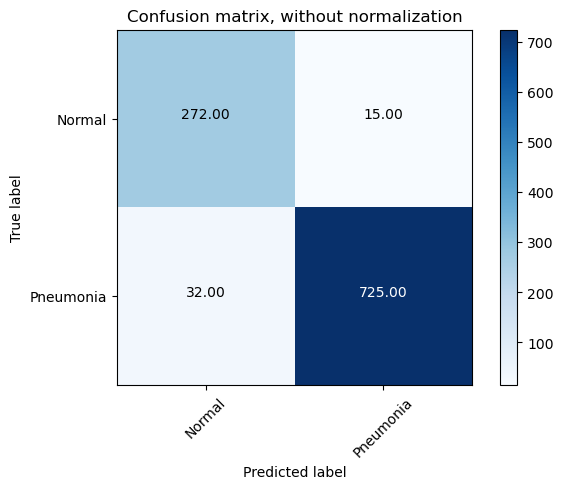

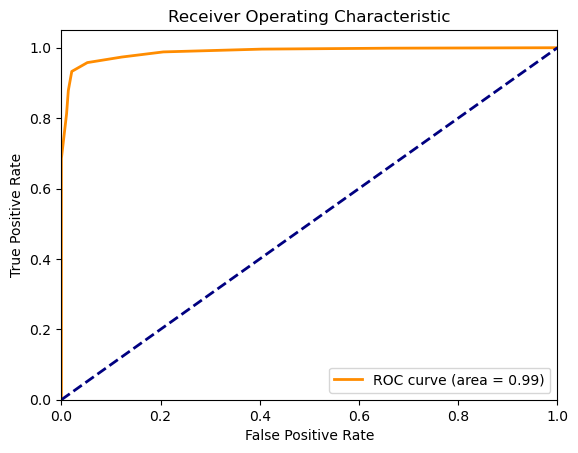

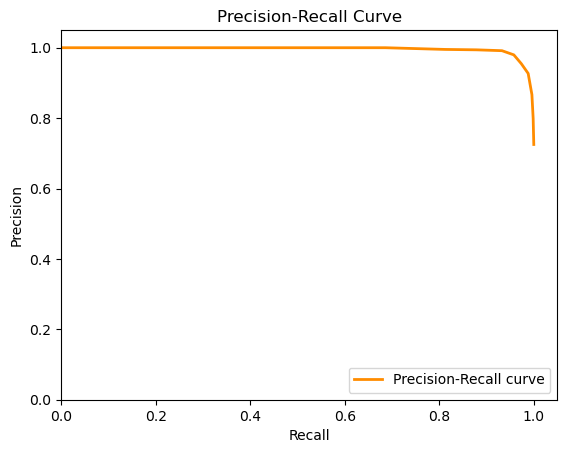

In [44]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    # Fix here: Directly use output from np.meshgrid
    x, y = np.meshgrid(tick_marks, tick_marks)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalised confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pneumonia'], title='Confusion matrix, without normalization')

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, grid_search.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


---
# **Explainable AI (XAI) Techniques**

## Feature Importance Using Permutation Importance

This plot illustrates the importance of features in the predictive model based on the decrease in accuracy when each feature's values are randomly shuffled:

- **X-axis (Feature Index)**: Indexes of individual features.
- **Y-axis (Mean Decrease in Accuracy)**: Decrease in model accuracy when the feature is permuted.

### Insights
- **Dominant Feature**: The first feature significantly impacts model accuracy, indicating high importance.
- **Other Features**: Subsequent features show minimal impact on model accuracy, suggesting less relevance.

### Implications
- The model's performance is highly dependent on a few key features, primarily the first one.
- This indicates potential for model simplification or a need for more robust feature selection to improve model reliability and generalization.


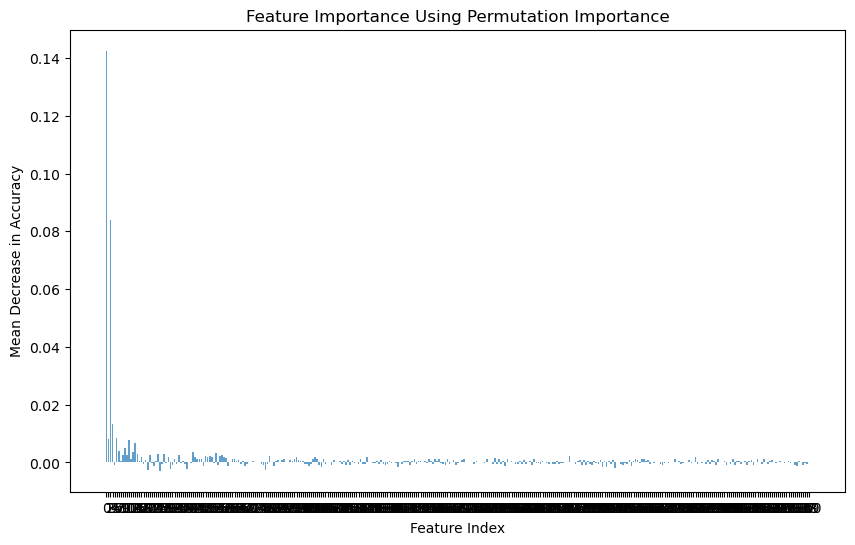

In [49]:
from sklearn.inspection import permutation_importance

# Ensure the KNN model from GridSearchCV is used
knn_best = grid_search.best_estimator_

# Perform permutation importance
results = permutation_importance(knn_best, X_test, y_test, scoring='accuracy')
importance = results.importances_mean

# Plotting the feature importance
plt.figure(figsize=(10, 6))
features = np.arange(len(importance))
plt.bar(features, importance, align='center', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease in Accuracy')
plt.title('Feature Importance Using Permutation Importance')
plt.xticks(features)
plt.show()

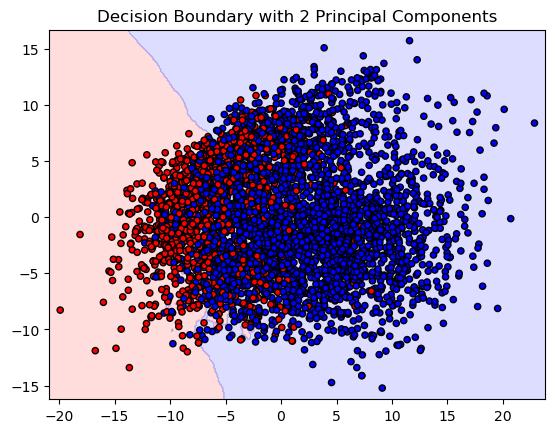

In [47]:
from matplotlib.colors import ListedColormap

# Reducing to two principal components for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)
X_test_2d = pca_2d.transform(X_test)

knn_2d = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_2d.fit(X_train_2d, y_train)

# Create a mesh to plot in
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the result
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the results
plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, s=20, edgecolor='k', cmap=ListedColormap(['#FF0000', '#0000FF']))
plt.title('Decision Boundary with 2 Principal Components')
plt.show()


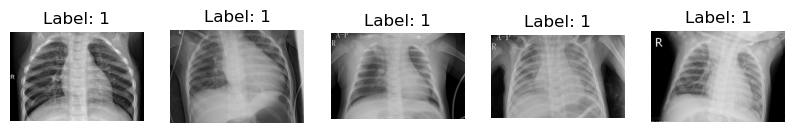

In [53]:
def plot_nearest_neighbors(test_idx, original_images):
    distances = pairwise_distances(X_test[test_idx:test_idx+1], X_train, metric='euclidean')
    nearest_neighbors = np.argsort(distances)[0][:5]

    plt.figure(figsize=(10, 2))
    for i, neighbor in enumerate(nearest_neighbors):
        ax = plt.subplot(1, 5, i + 1)
        # Access the original image instead of reshaping features
        img_path = original_images[neighbor]
        img = Image.open(img_path)
        plt.imshow(img.convert('L'), cmap='gray')
        plt.title(f'Label: {y_train[neighbor]}')
        plt.axis('off')
    plt.show()
    
# Example images
original_images = [os.path.join(normal_images_dir, f) for f in os.listdir(normal_images_dir)] + \
                  [os.path.join(pneumonia_images_dir, f) for f in os.listdir(pneumonia_images_dir)]
plot_nearest_neighbors(0, original_images)


# LIME (Local Interpretable Model-agnostic Explanations)

## LIME Explanations for Chest X-ray Classification

The provided visuasizations are outputs from the LIME tool, applied to three different chest X-ray images. Each image has been processed to highlight areas that significantly impact the model's prediction for class 0. The following is observed:

- **Red Areas**: Indicate strong positive influence on the model's confidence in predicting class 0.
- **Blue Areas**: Suggest negative influence, where features decrease the likelihood of class 0.
- **Gray Areas**: Neutral, with minimal impact on the prediction.

### Clinical Relevance
Thess visualizations assist in understanding how the model makes its decisions, which is crucial for clinical validation and ensuring the model's focus on medically relevant features. They also serve as a basis for further discussions on model training and potential biases in data handling.

### Insights
- **Image 1**: Shows strong indications supporting class 0, suggesting clear featsres recognized by the model.
- **Image 2**: Highlights significant doubt or contrary evidence against class 0, useful for identifying potential cases of misclassification or areas for retraining.
- **Image 3**: Presents a balanced view with mixed influences, highlighting the complexity and variability in medical image interpretations.

These insights help clinicians and researchers refine models and better ubehaviourd their behavior in practical diagnostic settings.


  0%|          | 0/1000 [00:00<?, ?it/s]

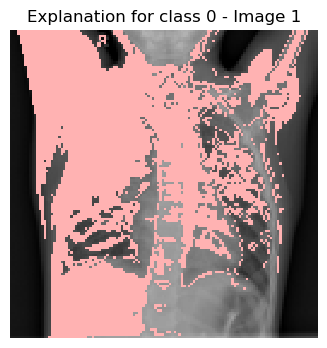

  0%|          | 0/1000 [00:00<?, ?it/s]

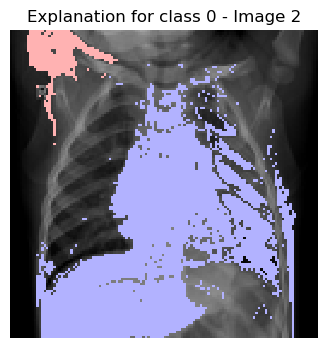

  0%|          | 0/1000 [00:00<?, ?it/s]

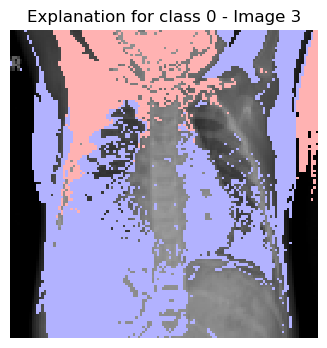

In [63]:
from lime import lime_image
from skimage.transform import resize
from skimage.color import gray2rgb, rgb2gray  # LIME expects images in RGB format

# Setup LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

def classify_images(images):
    """Process images for prediction."""
    processed_images = []
    for img in images:
        img = rgb2gray(img)  # Convert to grayscale
        img = resize(img, (128, 128))  # Resize to match training data preprocessing
        fd, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, feature_vector=True)
        processed_images.append(fd)
    
    processed_images = np.array(processed_images)
    processed_images = scaler.transform(processed_images)  # Apply scaling
    processed_images = pca.transform(processed_images)  # Apply PCA
    return grid_search.best_estimator_.predict_proba(processed_images)

# Normalise the image data for display
def normalize_image(img):
    return (img - img.min()) / (img.max() - img.min())

# Directory containing images
image_dir = './chest_xray/train/NORMAL/'
image_files = os.listdir(image_dir)[:3]  # Select the first three images for explanation

for idx, filename in enumerate(image_files):
    # Load and preprocess the image
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path).convert('L').resize((128, 128))
    image = gray2rgb(np.array(image))  # Convert grayscale to RGB as LIME expects RGB images

    # Generate explanation
    explanation = explainer.explain_instance(
        image.astype('double'),
        classify_images,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Display the explanation
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    # Normalize and plot
    temp = normalize_image(temp)
    plt.figure(figsize=(8, 4))
    plt.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
    plt.title(f"Explanation for class {explanation.top_labels[0]} - Image {idx+1}")
    plt.axis('off')  # Hide axes
    plt.show()

---
# **Testing The Developed KNN Model Through Predictions On Random Data**

Testing Normal Image: ./chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg


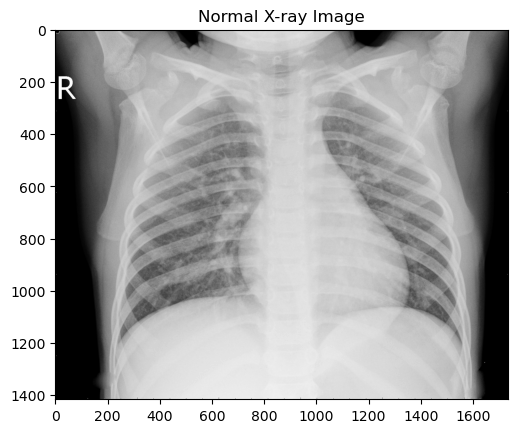

Prediction for Normal Image: Normal
Testing Pneumonia Image: ./chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg


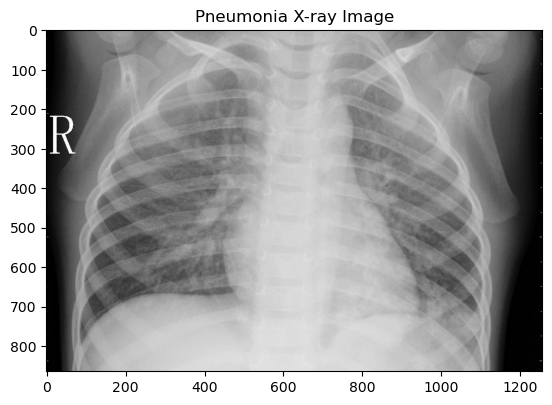

Prediction for Pneumonia Image: Pneumonia


In [64]:
def prepare_image(image_path):
    """Load an image, convert it to grayscale, resize it, and extract HOG features."""
    with Image.open(image_path).convert('L') as img:  # Convert image to grayscale 'L'
        img_resized = img.resize((128, 128))  # Resize image to match training
        img_array = np.array(img_resized)
        fd, _ = hog(img_array, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, feature_vector=True)
    return fd

def predict_image_class(image_path):
    """Prepare an image and predict its class using the KNN model."""
    features = prepare_image(image_path)
    features = scaler.transform([features])  # Scale features
    features = pca.transform(features)  # Apply PCA
    prediction = grid_search.best_estimator_.predict(features)
    return prediction

# Test the model with random images from both classes
def test_random_images():
    # Directories containing the validation X-ray images
    normal_xray_dir = './chest_xray/val/NORMAL/'
    pneumonia_xray_dir = './chest_xray/val/PNEUMONIA/'

    # Select a random normal image
    normal_images = os.listdir(normal_xray_dir)
    random_normal_image = random.choice(normal_images) if normal_images else None

    # Select a random pneumonia image
    pneumonia_images = os.listdir(pneumonia_xray_dir)
    random_pneumonia_image = random.choice(pneumonia_images) if pneumonia_images else None

    # Prepare and predict the normal image
    if random_normal_image:
        normal_image_path = os.path.join(normal_xray_dir, random_normal_image)
        print("Testing Normal Image:", normal_image_path)
        normal_img = mpimg.imread(normal_image_path)
        plt.imshow(normal_img, cmap='gray')
        plt.title('Normal X-ray Image')
        plt.show()
        normal_prediction = predict_image_class(normal_image_path)
        print("Prediction for Normal Image:", "Normal" if normal_prediction[0] == 0 else "Pneumonia")

    # Prepare and predict the pneumonia image
    if random_pneumonia_image:
        pneumonia_image_path = os.path.join(pneumonia_xray_dir, random_pneumonia_image)
        print("Testing Pneumonia Image:", pneumonia_image_path)
        pneumonia_img = mpimg.imread(pneumonia_image_path)
        plt.imshow(pneumonia_img, cmap='gray')
        plt.title('Pneumonia X-ray Image')
        plt.show()
        pneumonia_prediction = predict_image_class(pneumonia_image_path)
        print("Prediction for Pneumonia Image:", "Normal" if pneumonia_prediction[0] == 0 else "Pneumonia")

# Execute the test function
test_random_images()


# **Sources:**
